<a href="https://colab.research.google.com/github/esther0402/NN_experiments/blob/main/Sunspot_Prediction_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project uses the Daily Minimum Temperatures in Melbourne dataset (which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990), with Tensorflow's layers for processing sequence data such as Recurrent layers, LSTMs, or Convolutional layers to predict sunspots.


In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [4]:
TEMPERATURES_CSV = './daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")


Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



This code loads a helper function to plot the time series.

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

##Parsing the raw data
This function reads the data from the csv file.

In [8]:
def parse_data_from_file(filename):

    times = []
    temperatures = []

    with open(filename) as csvfile:

        reader = csv.reader(csvfile, delimiter=',')
        next(reader)

        for i, row in enumerate(reader):
            times.append(i) #append current index
            temperatures.append(float(row[1]))

    return times, temperatures

This code computes the `times` and `temperatures` and saves them as numpy arrays within the `G` dataclass, while plotting the time series.

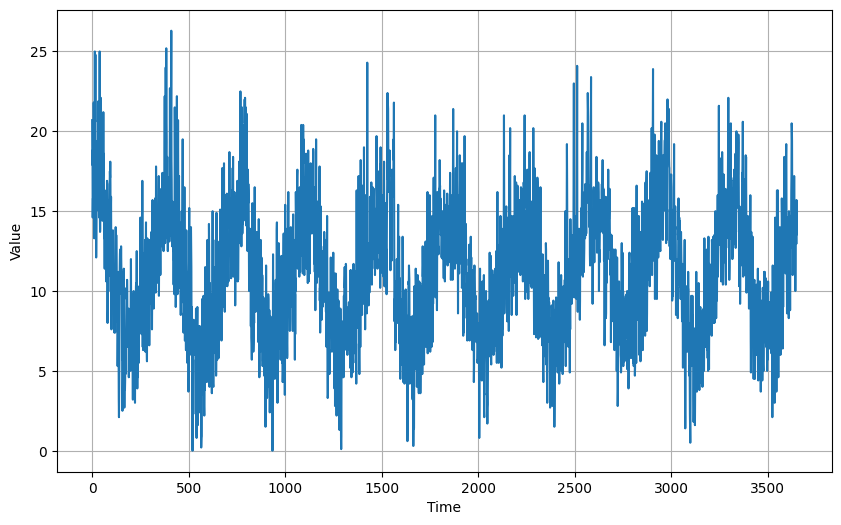

In [9]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

##Processing the data

In [10]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [11]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)


##Defining the model architecture

In [12]:
def create_uncompiled_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=60, kernel_size=3, #filters = 60
                              strides=1,
                              activation="relu",
                              padding="causal",
                              input_shape=[None,1]), #WINDOW_SIZE
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(30, activation = "relu"),
        tf.keras.layers.Dense(10, activation = "relu"),
        tf.keras.layers.Dense(1)
    ])

    return model


In [13]:
# Testing your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):

    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)

# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
1/1 [==============================] - 1s 1s/step
Your current architecture is compatible with the windowed dataset! :)


##Adjusting the learning rate
This code leverages Tensorflow's callbacks to dynamically vary the learning rate before doing the actualy training.

In [16]:
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    history = model.fit(dataset, epochs=50, callbacks=[lr_schedule])

    return history


In [17]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/50
77/77 [==============================] - 12s 123ms/step - loss: 9.0279 - mae: 9.5260 - lr: 1.0000e-04
Epoch 2/50
77/77 [==============================] - 11s 134ms/step - loss: 3.5146 - mae: 3.9831 - lr: 1.1220e-04
Epoch 3/50
77/77 [==============================] - 8s 96ms/step - loss: 2.0246 - mae: 2.4797 - lr: 1.2589e-04
Epoch 4/50
77/77 [==============================] - 9s 115ms/step - loss: 1.8253 - mae: 2.2743 - lr: 1.4125e-04
Epoch 5/50
77/77 [==============================] - 7s 92ms/step - loss: 1.7522 - mae: 2.2001 - lr: 1.5849e-04
Epoch 6/50
77/77 [==============================] - 8s 99ms/step - loss: 1.7177 - mae: 2.1673 - lr: 1.7783e-04
Epoch 7/50
77/77 [==============================] - 9s 111ms/step - loss: 1.6678 - mae: 2.1162 - lr: 1.9953e-04
Epoch 8/50
77/77 [==============================] - 9s 114ms/step - loss: 1.6552 - mae: 2.0997 - lr: 2.2387e-04
Epoch 9/50
77/77 [==============================] - 7s 90ms/step - loss: 1.6011 - mae: 2.0471 - lr: 2.511

(0.0001, 10.0, 0.0, 10.0)

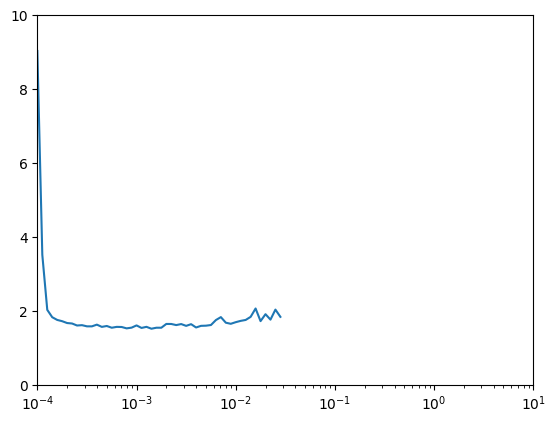

In [18]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

##Compiling the model
This code does the actual training that will be used to forecast the time series.

In [19]:
def create_model():

    model = create_uncompiled_model()

    learning_rate = 1e-3

    optimizer = tf.keras.optimizers.SGD(
        learning_rate=learning_rate,
        momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    return model

In [20]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 9s 91ms/step - loss: 4.1260 - mae: 4.5929
Epoch 2/50
77/77 [==============================] - 7s 90ms/step - loss: 1.7446 - mae: 2.1925
Epoch 3/50
77/77 [==============================] - 9s 115ms/step - loss: 1.6712 - mae: 2.1194
Epoch 4/50
77/77 [==============================] - 7s 92ms/step - loss: 1.5881 - mae: 2.0323
Epoch 5/50
77/77 [==============================] - 9s 115ms/step - loss: 1.5622 - mae: 2.0054
Epoch 6/50
77/77 [==============================] - 9s 114ms/step - loss: 1.6105 - mae: 2.0572
Epoch 7/50
77/77 [==============================] - 8s 94ms/step - loss: 1.5664 - mae: 2.0110
Epoch 8/50
77/77 [==============================] - 9s 112ms/step - loss: 1.5311 - mae: 1.9763
Epoch 9/50
77/77 [==============================] - 9s 115ms/step - loss: 1.5633 - mae: 2.0035
Epoch 10/50
77/77 [==============================] - 7s 90ms/step - loss: 1.5579 - mae: 2.0013
Epoch 11/50
77/77 [==============================] - 9

##Evaluating the forecast
This code evaluates the performance of the forecast.

In [21]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

##Computing the forecast

In [22]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

113/113 [==============================] - 5s 36ms/step


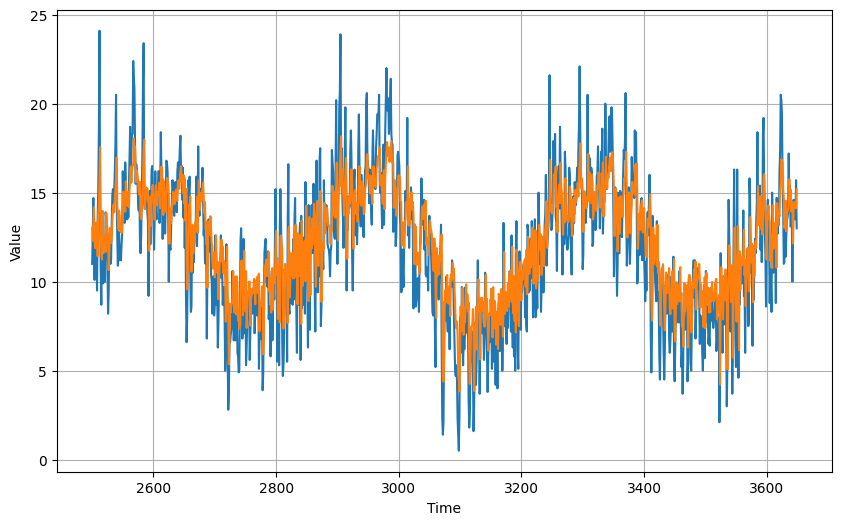

In [23]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [24]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.68, mae: 1.87 for forecast
